In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set dark theme for plots
plt.style.use("dark_background")
sns.set_palette("bright")

In [3]:
# Helper function to format plots
def format_plot(title, xlabel, ylabel):
    plt.title(title, color='white', fontsize=14)
    plt.xlabel(xlabel, color='white', fontsize=12)
    plt.ylabel(ylabel, color='white', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().tick_params(colors='white')

In [4]:
# Import games paid users data as users
users = pd.read_csv('../data/games_paid_users.csv')
print(users.dtypes)
print(users.head())

user_id                   object
game_name                 object
language                  object
has_older_device_model      bool
age                        int64
dtype: object
                    user_id game_name language  has_older_device_model  age
0  LuDHi0aoGmgpUtTGreh0fQ==    game 3       uk                    True   22
1  G9053rs6jbKItKUhrUdLew==    game 3       uk                   False   27
2  54ouP7lBhVCeV8ftS1Oj4Q==    game 3       ru                   False   21
3  ildaqkizLaFesmkjCvlzmQ==    game 3       uk                   False   24
4  ytNOQh7e6qNGQNC0T3RBxw==    game 3       ru                    True   26


In [5]:
# Import games payments data as payments
payments = pd.read_csv('../data/games_payments.csv')
print(payments.dtypes)
print(payments.head())

user_id                object
game_name              object
payment_date           object
revenue_amount_usd    float64
dtype: object
                    user_id game_name payment_date  revenue_amount_usd
0  fDgyPW0yy0+9ietMvl0vmA==    game 3   2022-08-18               15.87
1  MSxDpyVU8A+9Wgmnb8b1IQ==    game 3   2022-08-09               19.11
2  b6lW5fOrJiJUE7dwhEp9VQ==    game 3   2022-05-04               35.82
3  nklUUkirU5GYU5ZtNOgx8w==    game 3   2022-10-25               18.57
4  06RPvlsFPCmM9ag+iSM/Ag==    game 3   2022-08-14               18.90


In [6]:
# Convert payment_date to datetime
payments['payment_date'] = pd.to_datetime(payments['payment_date'])
payments['month'] = payments['payment_date'].dt.to_period('M').dt.to_timestamp()

In [7]:
# Monthly Recurring Revenue (MRR)
mrr = payments.groupby('month')['revenue_amount_usd'].sum().round(2).reset_index()
print("MRR:\n", mrr)

MRR:
        month  revenue_amount_usd
0 2022-03-01             1490.52
1 2022-04-01             3600.36
2 2022-05-01             4339.41
3 2022-06-01             5170.86
4 2022-07-01             6791.55
5 2022-08-01             7616.94
6 2022-09-01             7922.40
7 2022-10-01             9343.86
8 2022-11-01             8424.99
9 2022-12-01             8439.78


In [9]:
# Paid Users
paid_users = payments.groupby('month')['user_id'].nunique().reset_index()
print("Paid Users:", paid_users)

Paid Users:        month  user_id
0 2022-03-01       43
1 2022-04-01       73
2 2022-05-01      100
3 2022-06-01      111
4 2022-07-01      145
5 2022-08-01      165
6 2022-09-01      179
7 2022-10-01      199
8 2022-11-01      188
9 2022-12-01      189


In [11]:
# Average Revenue Per Paid User (ARPPU)
# Merge MRR and Paid Users by month
monthly_data = pd.merge(mrr, paid_users, on='month')
monthly_data.rename(columns={'revenue_amount_usd': 'monthly_revenue', 'user_id': 'paid_users'}, inplace=True)

# Calculate ARPPU per month
monthly_data['ARPPU'] = (monthly_data['monthly_revenue'] / monthly_data['paid_users']).round(2)

print(monthly_data[['month', 'ARPPU']])

       month  ARPPU
0 2022-03-01  34.66
1 2022-04-01  49.32
2 2022-05-01  43.39
3 2022-06-01  46.58
4 2022-07-01  46.84
5 2022-08-01  46.16
6 2022-09-01  44.26
7 2022-10-01  46.95
8 2022-11-01  44.81
9 2022-12-01  44.65


In [12]:
# New Paid Users
first_payments = payments.groupby('user_id')['payment_date'].min().reset_index()
first_payments['month'] = first_payments['payment_date'].dt.to_period('M').dt.to_timestamp()
new_paid_users = first_payments.groupby('month').size().reset_index(name='new_paid_users')
print("New Paid Users:\n", new_paid_users)

New Paid Users:
        month  new_paid_users
0 2022-03-01              43
1 2022-04-01              41
2 2022-05-01              40
3 2022-06-01              27
4 2022-07-01              44
5 2022-08-01              50
6 2022-09-01              38
7 2022-10-01              41
8 2022-11-01              27
9 2022-12-01              32


In [13]:
# New Monthly Recurring Revenue (MRR)
new_users_payments = payments.merge(first_payments[['user_id', 'month']], on=['user_id', 'month'])
new_mrr = new_users_payments.groupby('month')['revenue_amount_usd'].sum().round(2).reset_index(name='new_mrr')
print("New MRR:\n", new_mrr)

New MRR:
        month  new_mrr
0 2022-03-01  1490.52
1 2022-04-01  1749.51
2 2022-05-01  1572.78
3 2022-06-01   985.29
4 2022-07-01  1391.91
5 2022-08-01  1991.16
6 2022-09-01  1406.22
7 2022-10-01  1467.69
8 2022-11-01   862.53
9 2022-12-01  1267.92


In [14]:
# Churned Users
monthly_users = payments[['month', 'user_id']].drop_duplicates()
monthly_users['next_month'] = monthly_users['month'] + pd.offsets.MonthBegin(1)
churned = monthly_users.merge(monthly_users[['month', 'user_id']],
                              left_on=['next_month', 'user_id'],
                              right_on=['month', 'user_id'],
                              how='left',
                              suffixes=('', '_next'))
churned = churned[churned['month_next'].isna()]
churned_users = churned.groupby('month').size().reset_index(name='churned_users')
print("Churned Users:\n", churned_users)

Churned Users:
        month  churned_users
0 2022-03-01             11
1 2022-04-01             19
2 2022-05-01             26
3 2022-06-01             22
4 2022-07-01             41
5 2022-08-01             46
6 2022-09-01             46
7 2022-10-01             71
8 2022-11-01             64
9 2022-12-01            189


In [15]:
# Churn Rate
paid_users_monthly = monthly_users.groupby('month').size().reset_index(name='paid_users_count')
churn_rate = churned_users.merge(paid_users_monthly, on='month')
churn_rate['prev_paid_users'] = churn_rate['paid_users_count'].shift(1)
churn_rate['churn_rate'] = (churn_rate['churned_users'] / churn_rate['prev_paid_users']).round(4)
print("Churn Rate:\n", churn_rate[['month', 'churn_rate']])

Churn Rate:
        month  churn_rate
0 2022-03-01         NaN
1 2022-04-01      0.4419
2 2022-05-01      0.3562
3 2022-06-01      0.2200
4 2022-07-01      0.3694
5 2022-08-01      0.3172
6 2022-09-01      0.2788
7 2022-10-01      0.3966
8 2022-11-01      0.3216
9 2022-12-01      1.0053


In [16]:
# Churned Revenue
churned_revenue = churned.merge(payments, on=['user_id', 'month'])
churned_revenue = churned_revenue.groupby('month')['revenue_amount_usd'].sum().round(2).reset_index(name='churned_revenue')
print("Churned Revenue:\n", churned_revenue)

Churned Revenue:
        month  churned_revenue
0 2022-03-01           299.16
1 2022-04-01           629.97
2 2022-05-01           979.98
3 2022-06-01           879.54
4 2022-07-01          1518.72
5 2022-08-01          1361.52
6 2022-09-01          1734.18
7 2022-10-01          2800.26
8 2022-11-01          1946.58
9 2022-12-01          8439.78


In [17]:
# Revenue Churn Rate
revenue_churn_rate = churned_revenue.merge(mrr, on='month')
revenue_churn_rate['prev_mrr'] = revenue_churn_rate['revenue_amount_usd'].shift(1)
revenue_churn_rate['revenue_churn_rate'] = (revenue_churn_rate['churned_revenue'] / revenue_churn_rate['prev_mrr']).round(4)
print("Revenue Churn Rate:\n", revenue_churn_rate[['month', 'revenue_churn_rate']])

Revenue Churn Rate:
        month  revenue_churn_rate
0 2022-03-01                 NaN
1 2022-04-01              0.4227
2 2022-05-01              0.2722
3 2022-06-01              0.2027
4 2022-07-01              0.2937
5 2022-08-01              0.2005
6 2022-09-01              0.2277
7 2022-10-01              0.3535
8 2022-11-01              0.2083
9 2022-12-01              1.0018


In [18]:
# Expansion MRR
user_monthly_revenue = payments.groupby(['user_id', 'month'])['revenue_amount_usd'].sum().reset_index()
user_monthly_revenue['prev_revenue'] = user_monthly_revenue.groupby('user_id')['revenue_amount_usd'].shift(1)
user_monthly_revenue['revenue_diff'] = user_monthly_revenue['revenue_amount_usd'] - user_monthly_revenue['prev_revenue']
expansion_mrr = user_monthly_revenue[user_monthly_revenue['revenue_diff'] > 0].groupby('month')['revenue_diff'].sum().round(2).reset_index(name='expansion_mrr')
print("Expansion MRR:\n", expansion_mrr)

Expansion MRR:
        month  expansion_mrr
0 2022-04-01         886.65
1 2022-05-01         729.48
2 2022-06-01        1445.91
3 2022-07-01        1909.08
4 2022-08-01        1688.25
5 2022-09-01        1428.90
6 2022-10-01        2757.33
7 2022-11-01        2432.88
8 2022-12-01        2106.54


In [22]:
# Contraction MRR
neg_diff = user_monthly_revenue[user_monthly_revenue['revenue_diff'] < 0]
contraction_mrr = neg_diff.groupby('month')['revenue_diff'].sum().abs().round(2).reset_index()
contraction_mrr.rename(columns={'revenue_diff': 'contraction_mrr'}, inplace=True)
print("Contraction MRR:\n", contraction_mrr)

Contraction MRR:
        month  contraction_mrr
0 2022-04-01           227.16
1 2022-05-01          1123.20
2 2022-06-01          1042.50
3 2022-07-01          1370.79
4 2022-08-01          1682.40
5 2022-09-01          2305.80
6 2022-10-01          1950.39
7 2022-11-01          2624.94
8 2022-12-01          2777.73


In [23]:
# Customer Lifetime (LT)
user_periods = payments.groupby('user_id').agg({'payment_date': ['min', 'max']}).reset_index()
user_periods.columns = ['user_id', 'first_payment', 'last_payment']
user_periods['lifetime_days'] = (user_periods['last_payment'] - user_periods['first_payment']).dt.days
customer_lt = user_periods['lifetime_days'].mean().round(2)
print("Customer Lifetime (days):", customer_lt)

Customer Lifetime (days): 100.53


In [27]:
# Customer Lifetime Value (LTV)
user_periods = payments.groupby('user_id').agg({'payment_date': ['min', 'max']}).reset_index()
user_periods.columns = ['user_id', 'first_payment', 'last_payment']
user_periods['lifetime_days'] = (user_periods['last_payment'] - user_periods['first_payment']).dt.days
customer_lt = user_periods['lifetime_days'].mean().round(2)
print("Customer Lifetime (days):", customer_lt)

Customer Lifetime (days): 100.53


In [26]:
user_revenue = payments.groupby('user_id')['revenue_amount_usd'].sum().reset_index()
ltv = user_revenue['revenue_amount_usd'].mean().round(2)
print("LTV:", ltv)

LTV: 164.86


Visualizations

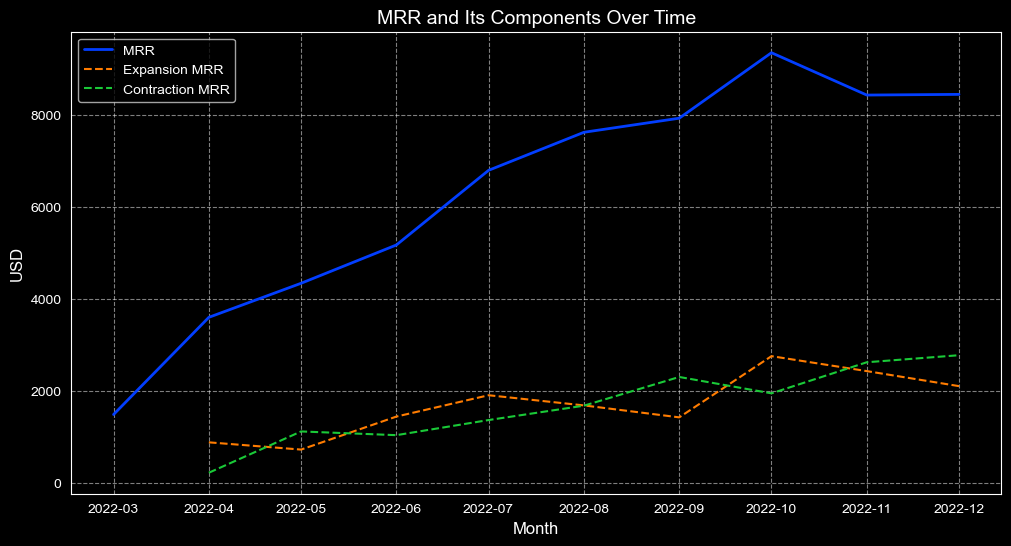

In [28]:
# Plot MRR, Expansion MRR, Contraction MRR
plt.figure(figsize=(12, 6))
plt.plot(mrr['month'], mrr['revenue_amount_usd'], label='MRR', linewidth=2)
plt.plot(expansion_mrr['month'], expansion_mrr['expansion_mrr'], label='Expansion MRR', linestyle='--')
plt.plot(contraction_mrr['month'], contraction_mrr['contraction_mrr'], label='Contraction MRR', linestyle='--')
format_plot('MRR and Its Components Over Time', 'Month', 'USD')
plt.show()

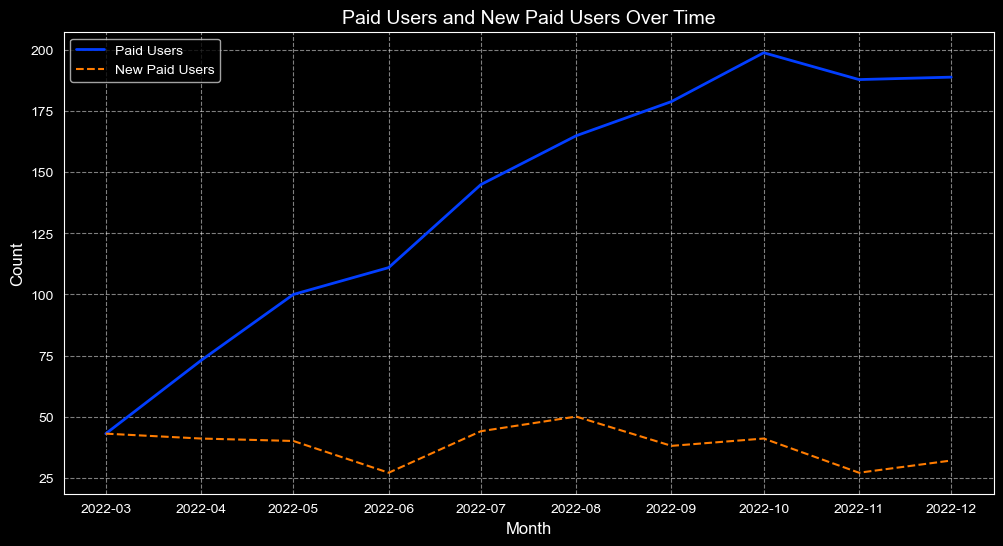

In [29]:
# Paid Users and New Paid Users
plt.figure(figsize=(12, 6))
plt.plot(paid_users_monthly['month'], paid_users_monthly['paid_users_count'], label='Paid Users', linewidth=2)
plt.plot(new_paid_users['month'], new_paid_users['new_paid_users'], label='New Paid Users', linestyle='--')
format_plot('Paid Users and New Paid Users Over Time', 'Month', 'Count')
plt.show()

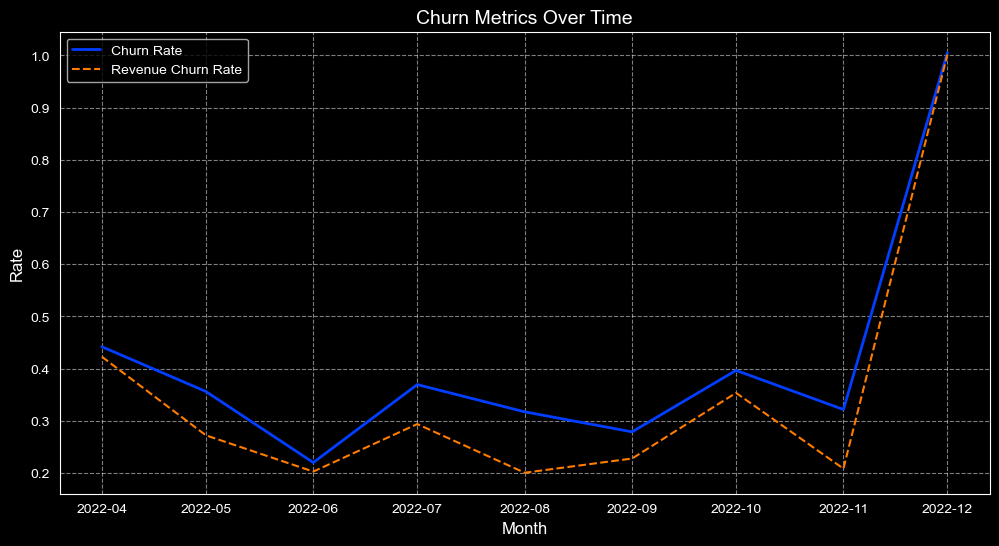

In [30]:
# Churn Rate and Revenue Churn Rate
plt.figure(figsize=(12, 6))
plt.plot(churn_rate['month'], churn_rate['churn_rate'], label='Churn Rate', linewidth=2)
plt.plot(revenue_churn_rate['month'], revenue_churn_rate['revenue_churn_rate'], label='Revenue Churn Rate', linestyle='--')
format_plot('Churn Metrics Over Time', 'Month', 'Rate')
plt.show()

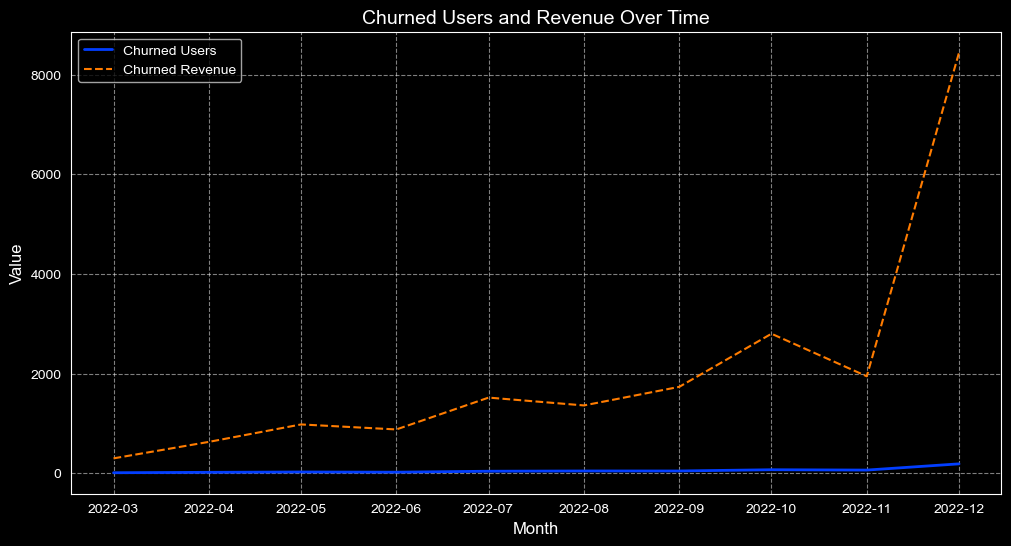

In [31]:
# Churned Users and Churned Revenue
plt.figure(figsize=(12, 6))
plt.plot(churned_users['month'], churned_users['churned_users'], label='Churned Users', linewidth=2)
plt.plot(churned_revenue['month'], churned_revenue['churned_revenue'], label='Churned Revenue', linestyle='--')
format_plot('Churned Users and Revenue Over Time', 'Month', 'Value')
plt.show()